# Описание проекта

Имеется размеченный датасет из отрывков мультсериала Симпсоны. Каждая картинка представлена в формате jpg c необходимой меткой - названием персонажа, изображенного на ней (метки классов представлены в виде названий папок, в которых лежат картинки).

Необходимо обучить классификатор на основе сверточных сетей, чтобы научиться отличать всех жителей Спрингфилда. Метрикой будет служить `Mean F1-Score`. Результат тестовой выборки оценивается в соревновании на kaggle.com:
https://www.kaggle.com/competitions/journey-springfield/

# Цель проекта

Получить классификатор со значением метрики `Mean F1-Score` не менее `0,97`.

# Загрузка файлов

## Импорт библиотек

In [ ]:
import gdown
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from torchvision import transforms, models
import torch
from torch.optim import Adam, lr_scheduler
from torch import nn
from torch.nn import functional as F
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score

In [ ]:
# разные режимы датасета
DATA_MODES = ['train', 'valid', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_WIDTH, RESCALE_HEIGHT = 224, 224
# работаем на видеокарте
device = "cuda" if torch.cuda.is_available() else "cpu"

## Загрузка файлов

Файлы с тренировочным и тестовым датасетом расположены на Гугл Диске. Загрузим их.

In [ ]:
url = 'https://drive.google.com/u/0/uc?id=1bqJZgdP1vMCkv_3hthOfw3j-YhQnMoII&confirm=t'
output = 'data.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/u/0/uc?id=1bqJZgdP1vMCkv_3hthOfw3j-YhQnMoII&confirm=t
To: /content/data.zip
100%|██████████| 546M/546M [00:13<00:00, 39.8MB/s]


'data.zip'

In [ ]:
!unzip -q data.zip -d data

## Разбивка на тренировочную, валидационную и тестовую выборки

Разобьем размеченную выборку на тренировочную и валидационную в отношении 3:1. При разбиении воспользуемся стратификацией.

In [ ]:
TRAIN_DIR = Path('data/train/simpsons_dataset')
TEST_DIR = Path('data/testset')

train_valid_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
train_valid_labels = [path.parent.name for path in train_valid_files]
train_files, valid_files = train_test_split(train_valid_files, test_size=0.25, \
                                          stratify=train_valid_labels, random_state=42)
numb_of_classes = len(set(train_valid_labels))

## Создание датасета

Создадим класс датасета. Все изображения приведем к одиннаковому размеру, для тренировочной выборки применим аугментацию (смещение и горизонтальное отражение).

In [ ]:
class SimpsonsDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()

        self.mode = mode
        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.files = files
        self.len = len(self.files)
        if mode != "test":
            self.labels = [path.parent.name for path in files]
            self.label_encoder = LabelEncoder()
            self.label_encoder.fit(self.labels)

    def __len__(self):
        return self.len

    def load_image(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        image = self.load_image(self.files[index])
        crop_height, crop_width = int(0.9 * image.size[0]), int(0.9 * image.size[1])
        if self.mode == 'train':
            transform = transforms.Compose([
                transforms.RandomCrop((crop_width, crop_height)),
                transforms.Resize((RESCALE_HEIGHT, RESCALE_WIDTH)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else:
            transform = transforms.Compose([
                transforms.Resize((RESCALE_WIDTH, RESCALE_HEIGHT)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        image = transform(image)
        if self.mode == 'test':
            return image
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            label = label_id.item()
            return image, label

Создадим функцию для просмотра изображения.

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
train_dataset = SimpsonsDataset(train_files, 'train')
valid_dataset = SimpsonsDataset(valid_files, 'valid')
test_dataset = SimpsonsDataset(test_files, 'test')

Выведем 9 случайных картинок, по 3 из каждого датасета.

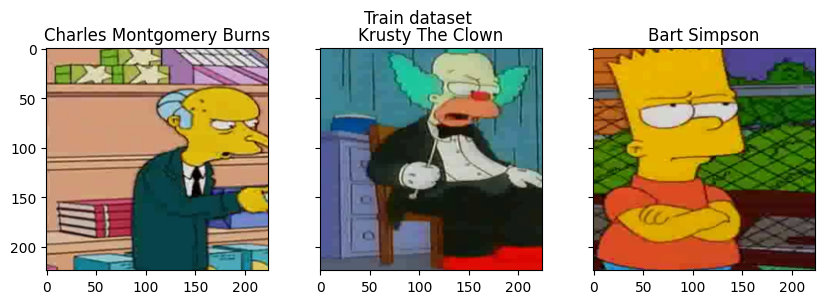

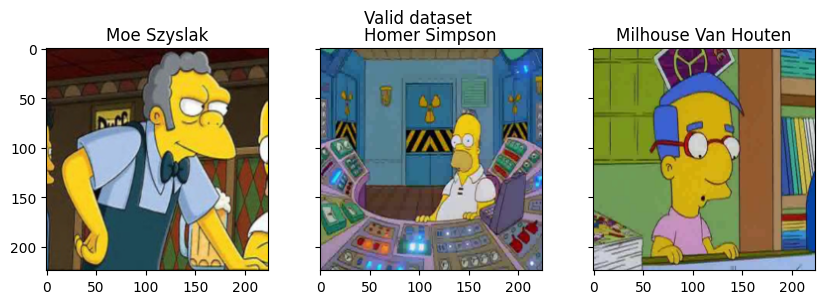

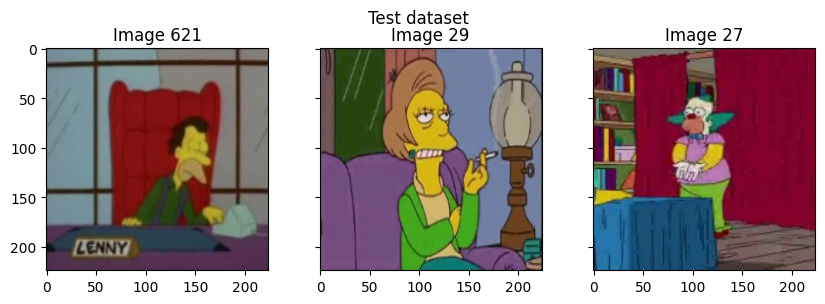

In [ ]:
for dataset, mode in zip([train_dataset, valid_dataset, test_dataset], DATA_MODES):
    fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(10, 3), \
                            sharey=True, sharex=True)
    plt.suptitle(f'{mode.capitalize()} dataset')
    plt.subplots_adjust(top=0.85)
    for fig_x in ax.flatten():
        random_characters = int(np.random.uniform(0, dataset.__len__()))
        if mode != 'test':
            image, label = dataset[random_characters]
            img_label = " ".join(map(lambda x: x.capitalize(),\
                        dataset.label_encoder.inverse_transform([label])[0].split('_')))
            imshow(image.data.cpu(), \
                  title=img_label,plt_ax=fig_x)
        else:
            image = dataset[random_characters]
            imshow(image.data.cpu(), \
                  title=f'Image {random_characters}',plt_ax=fig_x)
    plt.show()

## Баланс классов

Оценим баланс классов

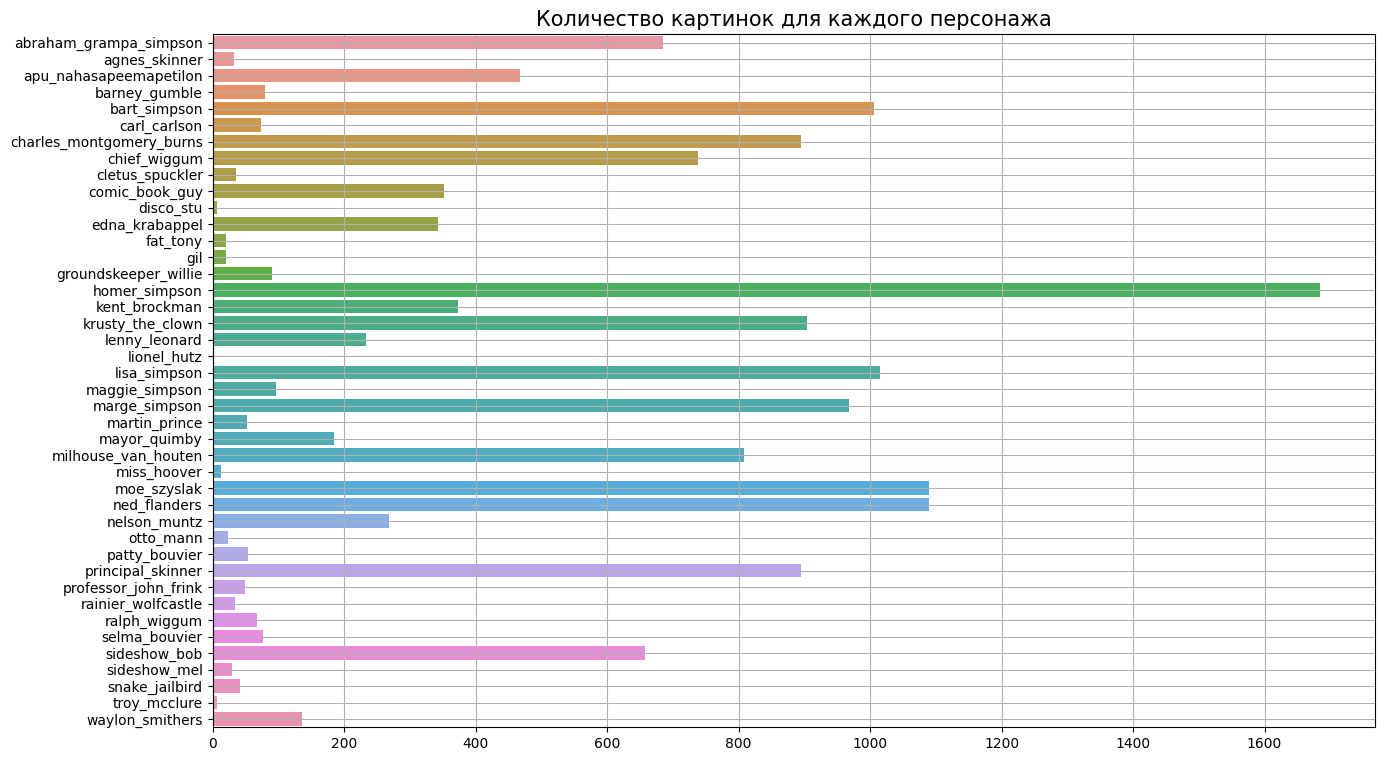

In [ ]:
value_counts = pd.Series(train_dataset.label_encoder.transform(train_dataset.labels)).value_counts()
value_counts.sort_index(inplace=True)
fig = plt.figure(figsize=(15, 9))
ax = sns.barplot(y=train_dataset.label_encoder.inverse_transform(value_counts.index), x=value_counts.values)
plt.title("Количество картинок для каждого персонажа", fontsize=15)
plt.grid(True)
plt.show()

В данных присутствует сильный дисбаланс классов. Устраним его, загружая объекты взвешенно (у классов с меньшим количеством объектов будут большие веса).

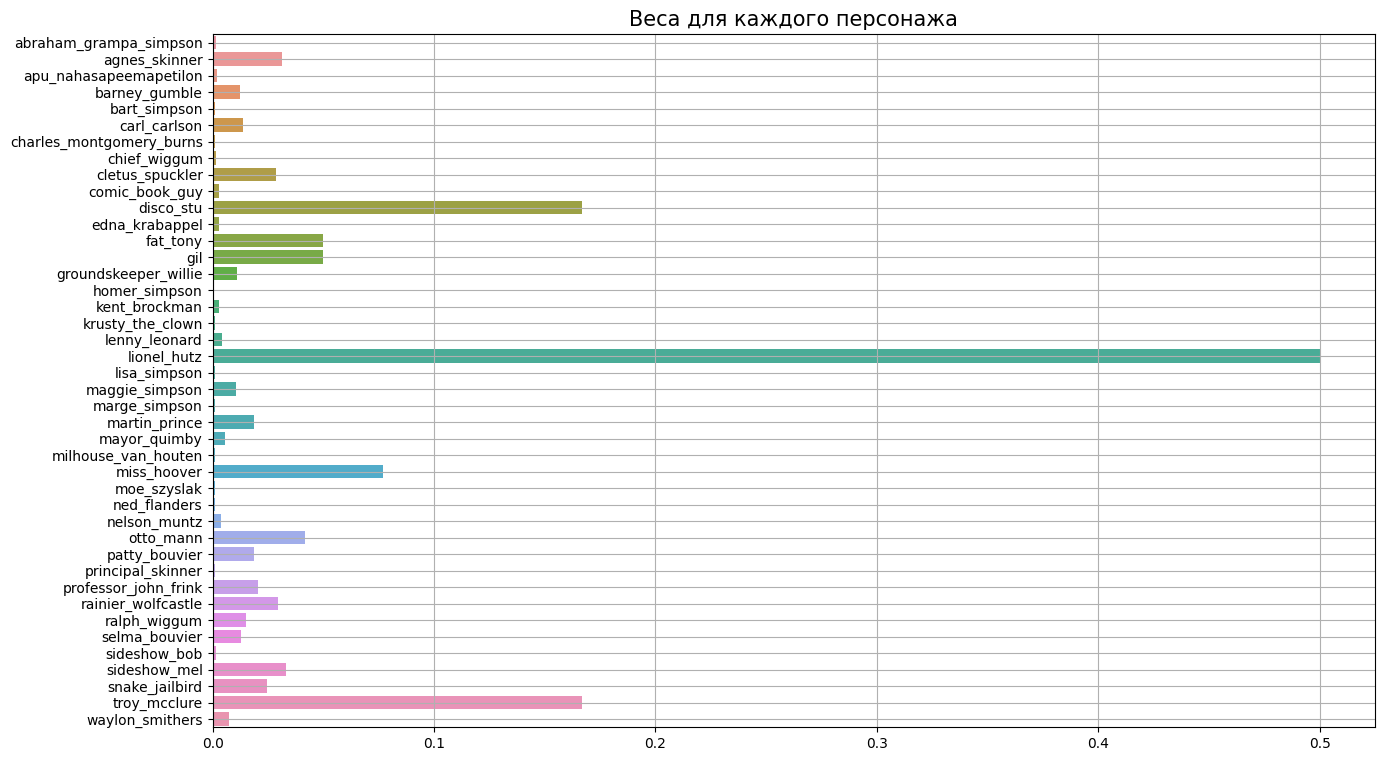

In [ ]:
value_counts = 1 / value_counts
fig = plt.figure(figsize=(15, 9))
ax = sns.barplot(y=train_dataset.label_encoder.inverse_transform(value_counts.index), x=value_counts.values)
plt.title("Веса для каждого персонажа", fontsize=15)
plt.grid(True)
plt.show()

Воспользуемся `WeightedRandomSampler`, чтобы загружать объекты взвешенно.

In [ ]:
sampler_train_wht = torch.utils.data.WeightedRandomSampler([value_counts[x[1]] for x in train_dataset],
                                                           train_dataset.__len__(), replacement=True)

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=64, sampler=sampler_train_wht)
valid_dataloader = DataLoader(valid_dataset, batch_size=64)

dataloader = {
    'train' : train_dataloader,
    'valid' : valid_dataloader
}

# Обучение модели

Напишем функцию для обучения модели.

In [ ]:
def fit_epoch(model, loss_func, optimizer, dataloader):
    running_loss = 0
    epoch_pred = []
    epoch_labels = []
    processed_size = 0

    model.train()
    for data in tqdm(dataloader, leave=False, desc=f"train iter:"):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        pred = torch.argmax(outputs, -1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        epoch_pred.append(pred.cpu().numpy())
        epoch_labels.append(labels.cpu().numpy())
        processed_size += inputs.size(0)

    epoch_pred = np.concatenate(epoch_pred)
    epoch_labels = np.concatenate(epoch_labels)
    epoch_acc = sum(epoch_pred == epoch_labels) / processed_size
    epoch_loss = running_loss / processed_size
    f1 = f1_score(epoch_labels, epoch_pred, average='weighted')

    return epoch_loss, epoch_acc, f1

def evaluate_epoch(model, loss_func, optimizer, dataloader):
    running_loss = 0
    epoch_pred = []
    epoch_labels = []
    processed_size = 0

    model.eval()
    for data in tqdm(dataloader, leave=False, desc=f"valid iter:"):
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            pred = torch.argmax(outputs, -1)

        running_loss += loss.item() * inputs.size(0)
        epoch_pred.append(pred.cpu().numpy())
        epoch_labels.append(labels.cpu().numpy())
        processed_size += inputs.size(0)

    epoch_pred = np.concatenate(epoch_pred)
    epoch_labels = np.concatenate(epoch_labels)
    epoch_acc = sum(epoch_pred == epoch_labels) / processed_size
    epoch_loss = running_loss / processed_size
    f1 = f1_score(epoch_labels, epoch_pred, average='weighted')

    return epoch_loss, epoch_acc, f1

In [ ]:
def train_model(epochs, model, loss_func, optimizer, dataloader, scheduler=None):
    losses = {'train': [], "valid": []}
    scores = {'train': [], "valid": []}
    accuracy = {'train': [], "valid": []}

    best_model_wts = model.state_dict()
    best_score = 0.0
    pbar = tqdm(range(epochs), desc="Epoch:")
    for epoch in pbar:
        for phase in ['train', 'valid']:
            if phase == 'train':
                epoch_loss, epoch_acc, epoch_f1 = fit_epoch(model, loss_func, optimizer, dataloader[phase])
            if phase == 'valid':
                epoch_loss, epoch_acc, epoch_f1 = evaluate_epoch(model, loss_func, optimizer, dataloader[phase])
            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f} F1: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, epoch_f1
            ))

            losses[phase].append(epoch_loss)
            scores[phase].append(epoch_f1)
            accuracy[phase].append(epoch_acc)
            if phase == 'valid' and epoch_f1 > best_score:
                best_score = epoch_f1
                best_model_wts = model.state_dict()
        if scheduler is not None:
            scheduler.step()
    model.load_state_dict(best_model_wts)
    return model, losses, scores

## ResNet 50

В качестве классификатора изображений воспользуемся сетью `ResNet50`. Для того, чтобы применить эту сеть к текущей задаче, загрузим модель с предобученными весами и изменим последний модуль на линейный слой с количеством нейронов на выходе, равным количеству классов.

### Загрузка и изменение архитектуры модели

In [ ]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 230MB/s]


In [ ]:
model.fc = nn.Linear(model.fc.in_features, numb_of_classes)
if device == 'cuda':
    model.cuda()

### Обучение модели

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

In [20]:
# Ниже можно загрузить уже обученную модель.
model, loss, f1 = train_model(25, model, criterion, optimizer, dataloader, scheduler)

Epoch::   0%|          | 0/25 [00:00<?, ?it/s]

train iter::   0%|          | 0/246 [00:00<?, ?it/s]

valid iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/246 [00:00<?, ?it/s]

valid iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/246 [00:00<?, ?it/s]

valid iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/246 [00:00<?, ?it/s]

valid iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/246 [00:00<?, ?it/s]

valid iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/246 [00:00<?, ?it/s]

valid iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/246 [00:00<?, ?it/s]

valid iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/246 [00:00<?, ?it/s]

valid iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/246 [00:00<?, ?it/s]

valid iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/246 [00:00<?, ?it/s]

valid iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/246 [00:00<?, ?it/s]

valid iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/246 [00:00<?, ?it/s]

valid iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/246 [00:00<?, ?it/s]

valid iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/246 [00:00<?, ?it/s]

valid iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/246 [00:00<?, ?it/s]

valid iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/246 [00:00<?, ?it/s]

valid iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/246 [00:00<?, ?it/s]

valid iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/246 [00:00<?, ?it/s]

valid iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/246 [00:00<?, ?it/s]

valid iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/246 [00:00<?, ?it/s]

valid iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/246 [00:00<?, ?it/s]

valid iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/246 [00:00<?, ?it/s]

valid iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/246 [00:00<?, ?it/s]

valid iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/246 [00:00<?, ?it/s]

valid iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/246 [00:00<?, ?it/s]

valid iter::   0%|          | 0/82 [00:00<?, ?it/s]

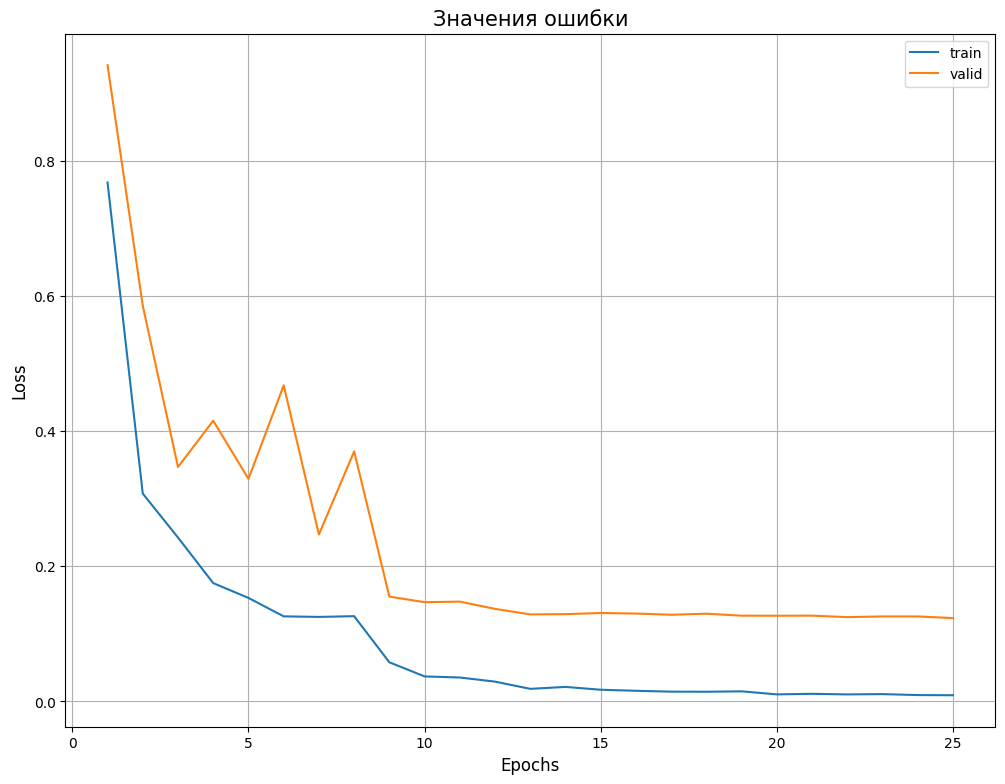

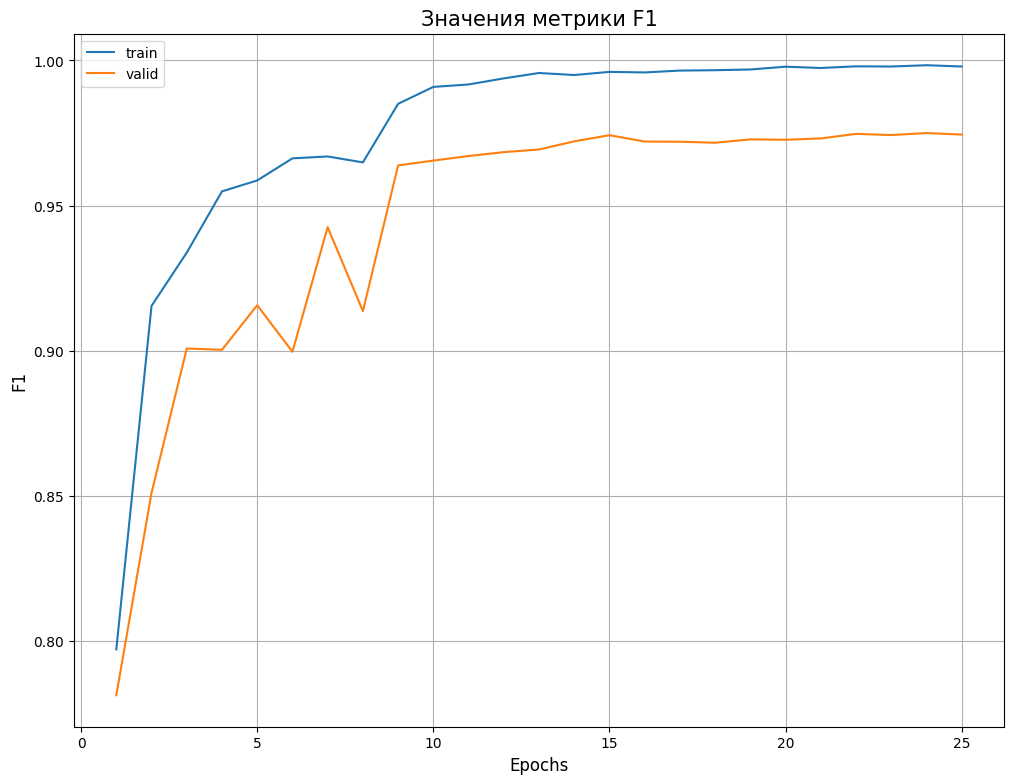

In [21]:
plt.figure(figsize=(12, 9))
for phase in ['train', 'valid']:
    plt.plot(np.arange(1, len(loss[phase])+1), loss[phase])
plt.title('Значения ошибки', fontsize=15)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.grid(True)
plt.legend(labels=['train', 'valid'])
plt.show()

plt.figure(figsize=(12, 9))
for phase in ['train', 'valid']:
    plt.plot(np.arange(1, len(f1[phase])+1), f1[phase])
plt.title('Значения метрики F1', fontsize=15)
plt.ylabel('F1', fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.grid(True)
plt.legend(labels=['train', 'valid'])
plt.show()
plt.show()

### Дообучение на валидационной выборке

Дообучим модель на валидационной выборке.

In [30]:
optimizer = Adam(model.parameters(), lr=0.00001)

In [31]:
pbar = tqdm(range(5), desc="Epoch:")
for epoch in pbar:
    model.train()
    running_loss = 0
    processed_size = 0

    for data in tqdm(valid_dataloader, leave=False, desc=f"train iter:"):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        pred = torch.argmax(outputs, -1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        processed_size += inputs.size(0)


    epoch_loss = running_loss / processed_size

    pbar.set_description('Loss: {:.4f}'.format(epoch_loss))

Epoch::   0%|          | 0/5 [00:00<?, ?it/s]

train iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/82 [00:00<?, ?it/s]

train iter::   0%|          | 0/82 [00:00<?, ?it/s]

Сохраним обученную модель.

In [ ]:
torch.save(model.state_dict(), 'resnet50_train_and_valid_simpsons.pth')

### Загрузка обученной модели

Загрузим обученную модель.

In [ ]:
url = 'https://drive.google.com/u/0/uc?id=1-1Zd_g1DtnAxi2MvKdiZYHfM35rlZfzX&confirm=t'
output = 'resnet50_train_and_valid_simpsons.pth'
gdown.download(url, output, quiet=False)
model.load_state_dict(torch.load('resnet50_train_and_valid_simpsons.pth'))

# Предсказание по тестовой выборке

С помощью обученной модели определим персонажей на тестовой выборке.

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [33]:
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=50)
probs = predict(model, test_loader)
preds = train_dataset.label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

Выведем 8 случайных картинок из тестовой выборки с предсказанным значением.

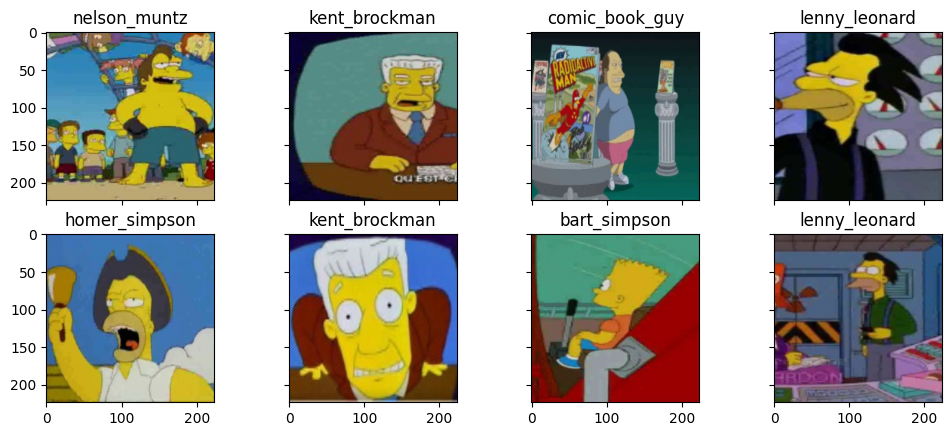

In [46]:
fig, ax = plt.subplots(nrows=2, ncols=4,figsize=(12, 5), \
                        sharey=True, sharex=True)
# plt.suptitle(f'{mode.capitalize()} dataset')
plt.subplots_adjust(top=0.85)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, test_dataset.__len__()))
    image = test_dataset[random_characters]
    imshow(image.data.cpu(), \
          title=preds[random_characters], plt_ax=fig_x)
plt.show()

Сохраним результат для тестовой выборки и отправим его для оценки.

In [47]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
my_submit.to_csv('/content/gdrive/MyDrive/ML projects/CV simpsons/my_submit.csv', index=False)

Результат на тестовой выборке `0.99362`.

Ссылка на таблицу лидеров для соревнования на kaggle.com:
https://www.kaggle.com/competitions/journey-springfield/leaderboard

# Вывод

В ходе данного проекта были выполнены следующие действия:
- изучение и подготовка данных для дальнейшего использования (проверка баланса классов, выделение имен персонажей, создание классов загрузчиков данных с учетом дисбаланса классов)
- загрузка обученной модели (`ResNet50`) и изменение последнего модуля под текущую задачу
- дообучение модели
- проверка модели на тестовой выборке.

В результате проекта был получен классификатор, который показал значение метрики `F1 = 0.99362`, что значительно выше требуемого. Из этого можно сделать вывод, что классификатор подходит для выполнения поставленной задачи.